In [1]:
from __future__ import annotations
import hashlib
import binascii
import os
from pydantic import BaseModel
import json
from decimal import Decimal
from typing import List, Tuple
import pprint
from binarytree import build
from itertools import groupby

# I. Main Data Strucutre

In [2]:
# Define Asset Model
class AssetModel(BaseModel):
    coin: str
    amount: Decimal

    @classmethod
    def combine_same_coin_asset(cls, asset_model_list: List[AssetModel]) -> List[AssetModel]:
        asset_model_list = sorted(asset_model_list, key=lambda asset: asset.coin)
        new_combine_list: List[AssetModel] = []
        for key_coin, group_asset_list in groupby(asset_model_list, lambda asset: asset.coin):
            total_coin_value = Decimal(str(sum([asset.amount for asset in group_asset_list])))
            new_combine_list.append(AssetModel(coin=key_coin, amount=total_coin_value))
        return new_combine_list

    @classmethod
    def is_all_positive(cls, asset_model_list: List[AssetModel]) -> bool:
        if len(asset_model_list) == 0:
            return True
        # any zero will return true
        return all(asset.amount >= 0 for asset in asset_model_list)

    def __str__(self):
        return f'{self.coin}:{self.amount}'


# Define user balance model
class UserBalanceModel(BaseModel):
    user_id: str
    balance: List[AssetModel] = []
    salt: str = binascii.hexlify(os.urandom(32)).decode()

    def json(self, **kwargs):
        return json.dumps(
            {
                'user_id': self.user_id,
                'balance': ','.join([str(asset) for asset in self.balance]),
                'salt': self.salt,
            }, **kwargs,
        )

# II. Main logic for Merkle Tree

In [3]:
# Mathematical helper methods
def hash(x):
    return hashlib.sha256(x).digest()


def log2(x):
    return len(bin(x)) - 2


def get_next_power_of_2(x):
    return 2 * get_next_power_of_2((x + 1) // 2) if x > 1 else 1


# This gets converted into a leaf, which does not reveal the user_id
def userdata_to_leaf(user_data: UserBalanceModel) -> Tuple[bytes, List[AssetModel]]:
    user_data_string = user_data.json(sort_keys=True, separators=(',', ':')).encode('utf-8')
    # print(user_data_string)
    return hash(user_data_string), user_data.balance


# The function for computing a parent node given two child nodes
def combine_tree_nodes(L, R) -> Tuple[bytes, List[AssetModel]]:
    L_hash, L_balance = L
    R_hash, R_balance = R
    # Make sure all asset's amount is positive
    assert AssetModel.is_all_positive(L_balance) and AssetModel.is_all_positive(R_balance) >= 0
    # Create a dictionary to set the left hash, left balance, right hash, right balance
    hash_dict = {
        'L_hash': binascii.hexlify(L_hash).decode(),
        'L_balance': ','.join([str(balance) for balance in L_balance]),
        'R_hash': binascii.hexlify(R_hash).decode(),
        'R_balance': ','.join([str(balance) for balance in R_balance]),
    }

    new_hash = hash(
        json.dumps(
            hash_dict, sort_keys=True,
            separators=(',', ':'),
        ).encode('utf-8'),
    )
    new_balance = AssetModel.combine_same_coin_asset(L_balance + R_balance)

    return new_hash, new_balance


# Builds a full Merkle tree. Stored in flattened form where
# node i is the parent of nodes 2i and 2i+1
def build_merkle_sum_tree(user_table: List[UserBalanceModel]):
    tree_size = get_next_power_of_2(len(user_table))
    tree = (
        [EMPTY_NODE] * tree_size
        + [userdata_to_leaf(user) for user in user_table]
        + [EMPTY_LEAF for _ in range(tree_size - len(user_table))]
    )
    for i in range(tree_size - 1, 0, -1):
        tree[i] = combine_tree_nodes(tree[i * 2], tree[i * 2 + 1])
    return tree


# Root of a tree is stored at index 1 in the flattened form
def get_root(tree):
    return tree[1]


# Get user tree index
def get_user_tree_index(tree, user_index) -> int:
    # ^ = bitwise xor, x ^ 1 = sister node of x
    index_in_tree = user_index + len(tree) // 2
    return index_in_tree


# Gets a proof for a node at a particular index
def get_proof(tree, index):
    branch_length = log2(len(tree)) - 1
    index_in_tree = get_user_tree_index(tree, index)
    return [tree[(index_in_tree // 2**i) ^ 1] for i in range(branch_length)]


# Verifies a proof (duh)
def verify_proof(user_data: UserBalanceModel, index, user_table_size, root, proof):
    leaf = userdata_to_leaf(user_data)
    branch_length = log2(get_next_power_of_2(user_table_size)) - 1
    for i in range(branch_length):
        if index & (2**i):
            leaf = combine_tree_nodes(proof[i], leaf)
        else:
            leaf = combine_tree_nodes(leaf, proof[i])
    return leaf == root


# Get user visibility node
def get_user_visibility_leaf(user_data: UserBalanceModel, index, user_table_size, root, proof):
    leaf = userdata_to_leaf(user_data)
    branch_length = log2(get_next_power_of_2(user_table_size)) - 1
    leaf_list = []
    for i in range(branch_length):
        if index & (2**i):
            leaf = combine_tree_nodes(proof[i], leaf)
            leaf_list.append(leaf)
            leaf_list.append(proof[i])
        else:
            leaf = combine_tree_nodes(leaf, proof[i])
            leaf_list.append(leaf)
            leaf_list.append(proof[i])
    return leaf_list

# III. Run Test for Merkle Tree

## a. Define User data

In [4]:
EMPTY_LEAF: Tuple[bytes, List[AssetModel]] = (b'\x00' * 32, [])
EMPTY_NODE: Tuple[bytes, List[AssetModel]] = (b'\x00' * 32, [])
user_json_table = [
    UserBalanceModel(
        user_id='Alice',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='BTC', amount=Decimal('20.33')),
            AssetModel(coin='ETH', amount=Decimal('10.12')),
        ],
    ),
    UserBalanceModel(
        user_id='Bob',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='BTC', amount=Decimal('0.2')),
            AssetModel(coin='ETH', amount=Decimal('11.3')),
        ],
    ),
    UserBalanceModel(
        user_id='Charlie',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='USDC', amount=Decimal('343.22')),
            AssetModel(coin='USDT', amount=Decimal('10000.34')),
        ],
    ),
    UserBalanceModel(
        user_id='David',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='USDC', amount=Decimal('883.12')),
            AssetModel(coin='BTC', amount=Decimal('164')),
        ],
    ),
    UserBalanceModel(
        user_id='Eve',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='BTC', amount=Decimal('870')),
            AssetModel(coin='USDT', amount=Decimal('219.238')),
        ],
    ),
    UserBalanceModel(
        user_id='Fred',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='ETH', amount=Decimal('6')),
            AssetModel(coin='USDC', amount=Decimal('8234.234')),
        ],
    ),
    UserBalanceModel(
        user_id='Greta',
        salt=binascii.hexlify(os.urandom(32)).decode(),
        balance=[
            AssetModel(coin='USDT', amount=Decimal('30.238')),
        ],
    ),
    # UserBalanceModel(
    #     user_id="Henry",
    #     salt=binascii.hexlify(os.urandom(32)).decode(),
    #     balance=[
    #         AssetModel(coin="BTC", amount=Decimal("90")),
    #         AssetModel(coin="USDC", amount=Decimal("214.3")),
    #         AssetModel(coin="USDT", amount=Decimal("1111")),
    #     ]),
]

## b. Build Tree

In [5]:
tree = build_merkle_sum_tree(user_json_table)

## c. Show Merkle Tree

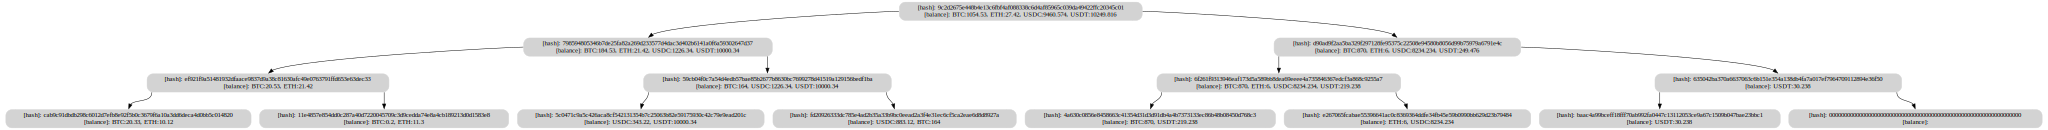

In [6]:
# merkle tree hash code
hash_tree = build(
    [f'[hash]: {binascii.hexlify(leaf[0]).decode()}\\n [balance]: {", ".join([str(balance) for balance in leaf[1]])}' for leaf in tree if leaf is not EMPTY_NODE],
)
graphviz_tree = hash_tree.graphviz()
graphviz_tree.render('data/Merkle_Tree')
graphviz_tree

## c. Show Balance in Tree

Balance Tree:


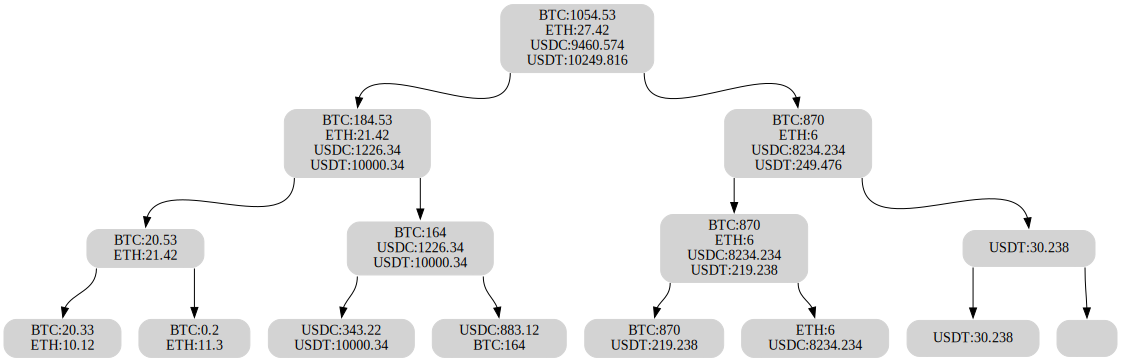

In [7]:
tree_balance_list = ["\\n".join([str(i) for i in item[1]]) for item in tree if item is not EMPTY_NODE]
binary_tree = build(tree_balance_list)
print("Balance Tree:")
graphviz_balance_tree = binary_tree.graphviz()
graphviz_balance_tree.render('data/Balance_Tree')
graphviz_balance_tree

## d. Show User in Tree and it's visibility

In [8]:
def show_user_visibility(tree, user_index):
    now_user_data = user_json_table[user_index]
    root = get_root(tree)
    verfiy_proof = get_proof(tree, user_index)
    verify_leaf_list = [item[0] for item in get_user_visibility_leaf(now_user_data, user_index, len(user_json_table), root, verfiy_proof)]

    tree_balance_list = [item for item in tree if item is not EMPTY_NODE]
    # user index in tree
    user_index_in_tree = get_user_tree_index(tree, user_index)
    # generate bt_tree and put user location
    bt_tree = ["\\n".join([str(i) for i in item[1]]) if item[0] in verify_leaf_list else ' ' for item in tree_balance_list]
    bt_tree[user_index_in_tree - 1] = f"[{now_user_data.user_id}]"

    # print
    binary_tree = build(bt_tree)
    print(f'User [{now_user_data.user_id}] visibility:\n')
    print(f'User data: {", ".join([str(b) for b in now_user_data.balance])}')
    return binary_tree.graphviz()

User [Alice] visibility:

User data: BTC:20.33, ETH:10.12


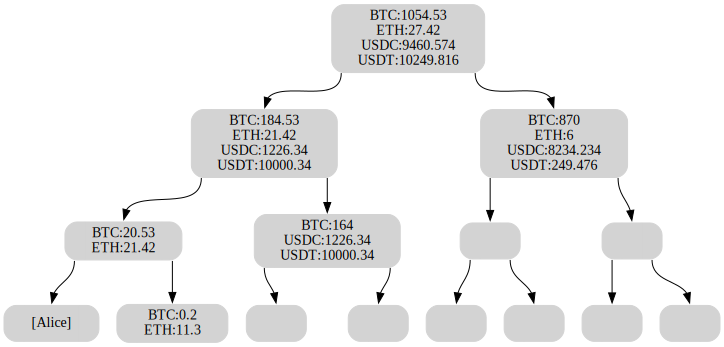

In [9]:
# show alice
show_user_visibility(tree, 0)

User [Fred] visibility:

User data: ETH:6, USDC:8234.234


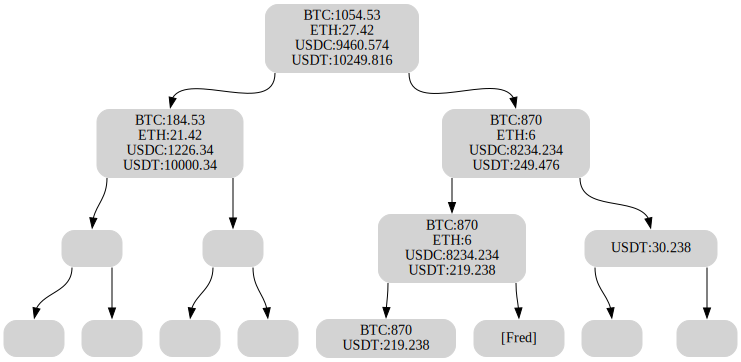

In [10]:
# show Fred visibility
show_user_visibility(tree, 5)

## f. Print User Data

In [11]:
# print data 
for user in user_json_table:
    print("[json data]:")
    print(user.json(indent=2))
    print(f"\n[json data hash]: {binascii.hexlify(userdata_to_leaf(user)[0]).decode()}\n")
    print("-------------------------------------------------------------------------------------")

[json data]:
{
  "user_id": "Alice",
  "balance": "BTC:20.33,ETH:10.12",
  "salt": "c6903fb8751f9148c76331d0c8e40643db37f1bf22d2b5b207483e03241a89e1"
}

[json data hash]: cab9c91dbdb298c6012d7efb8e92f5b0c3679f6a10a3dd6deca4d0bb5c014820

-------------------------------------------------------------------------------------
[json data]:
{
  "user_id": "Bob",
  "balance": "BTC:0.2,ETH:11.3",
  "salt": "65908c1a86ce22b7a34fd7d5075f4dfbe248e9c224c1432f9252dcaf9666c450"
}

[json data hash]: 11e4857e854dd0c287a40d7220045709c3d9cedda74e8a4cb189213d0d1583e8

-------------------------------------------------------------------------------------
[json data]:
{
  "user_id": "Charlie",
  "balance": "USDC:343.22,USDT:10000.34",
  "salt": "19e9a64f1060a7d457d2b408032d887193c03531a63f4a64f52cddfb7a0597a2"
}

[json data hash]: 5c0471c9a5c426aca8cf542131354b7c25063b82e59175930c42c79e9ead201c

-------------------------------------------------------------------------------------
[json data]:
{
  "user_id": 